# Soru 1: One hot encoding modelin görmediği veriye nasıl uygulanır?

Kategorik değişkenlerde:
- Scikit-learn'ün OneHotEncoder aracındaki handle_unknown argümanı 'ignore' yapılarak daha önce görmediği bi kategori gördüğünde hata vermek yerine, bütün kolonlara 0 vererek o kolonların hiçbirine ait olmadığını işaretlemiş olur. Bu sayede desteki hatanın önüne geçilmiş olur.<br>
<!-- end of the list -->

Sayısal değişkenlerde:
- Eğer bir regresyon modeli oluşturuluyorsa sayısal değişkenlerde onehot encoding yapmaya gerek olmayabilir. Sadece scaling yapmak yeterlidir.
- Eğer bir klasifikasyon modeli oluşturuyorsak bu modele sürekli bir değişken bırakmak modelin başarısız olmasına sebep olabilir. Bu sebeple sürekli değişkenler gruplandırılıp encode edilmelidir. Bu durumda ise ordinal bir değişken elde edildiği için onehot yerine label encoding kullanmak daha doğru bir seçim olabilir.

# Soru 2: Labelencoding'de ilgili kolon için ölçeklendirme nasıl yapılır? (Verinin doğru etkisiyle sayısal olarak dönüştürülmesi)

- Eğer değişken ordinalse label encoding yapmak, onehot encoding yapmaya göre daha doğru bir seçim olabilir.
- Label encoding yaparken dikkat edilmesi gereken temel şey değişken sıralanabilir olduğu için verilen sayıların da değişkenle aynı sırada olmasıdır.
- Örneğin: Güzel:3 , Orta:2 , Kötü:1 doğru bir label encoding işlemidir çünkü sıralama doğru şekilde yapılmıştır.
- scikit-learn'deki LabelEncoder bu iş için doğru araç değildir çünkü bu sıralamayı kullanıcının yapmasına izin vermeyip otomatik olarak yapmaktadır. Dökümantasyonunda da LabelEncoder'ın sadece y değişkeni için kullanılması gerektiği belirtilmiştir.
- X değişkeninde scikit-learn'ün OrdinalEncoder aracı kullanılarak label encoding işlemi yapılabilir.
- Eğer klasifikasyon modeli kuruluyorsa ve hedef kolon(y) sayısal değerler değilse onun için scikit-learn'ün LabelEncoder aracı kullanılabilir.

# Soru 3: Imbalance datasette train test split yaparken neleri göz önünde bulundurmalıyız?

- Imbalance bir datasette bir değişken çok az bulunduğu için şans eseri bu az bulunan değişken büyük oranda train'de veya büyük oranda test'te birikme ihtimali vardır. Bunun olmamasına dikkat edilir.
- Bunun olmaması için train_test_split kullanılıyorsa ayrıldıktan y kolonundaki sınıfların oranı ana datasetteki sınıfların oranına yaklaşık eşit mi diye kontrol edilmelidir.
- train_test_split yerine Kfold kullanılıyorsa, StratifiedKFold kullanılarak bu dengesizlik önlenebilir.

# Soru 4: Validation dataseti (modelin görmediği) nasıl oluşturulur ve nasıl predict etmeye hazır hale getirilir?

Temelde dikkat edilmesi gereken şey buradaki verinin model canlıya alındığında gelecek veriye en yakın şekilde seçilmesi ve aynı işlemlerden geçmesidir çünkü validation modelin canlıya alınmasının bir provasıdır. Bunun için dikkat edilmesi gereken bir çok nokta vardır.

Oluştururken dikkat edilmesi gerekenler:
- Veri zamana bağlı bir veriyse, tarihe göre sıralanıp en son tarihten validation ayrılmalıdır çünkü canlı modelde de eski tarihli verilerle eğitilip güncel veri tahmin edilmeye çalışılacaktır.
- Canlı veriye uygulanamayacak bir işlem varsa o işlem uygulanmadan önce ana datasetten ayrılmalıdır.
<!-- end of the list -->

Düzenlerken dikkat edilmesi gerekenler:
- Train datasına uygulanan şeyler validation datasına da uygulanır.
- NaN değerler train datasının doldurulduğu yöntemle doldurulur.
- Train datasında yapılan gruplandırmalar aynı şekilde yapılır.
- Train datasında fit edilip sonra train datasını transform eden scaler ile validation dataseti de transform edilir.(Fit edilmez çünkü canlı modelde gelecek tek tek verilerde fit işlemi yapılamaz ama fit edilmiş scaler ile transform edilebilir)
- Train datasında kullanılan encoderlar kullanılarak validation dataseti de encode edilir.(handle_unknown seçeneği ile iki encoder'da da daha önce görülmemiş veri için hata oluşmasına engel olunabilir.)
- SMOTE kullanılamaz çünkü over-sampling bir datasete uygulanabilir ama validation'da amacımız model canlıdayken olacağı gibi gelecek tek tek verileri doğru bi şekilde tahminlemek. Tek bir veriye over-sampling yapılamayacağı için SMOTE kullanılmaz.

# Soru 5: predict_proba metoduyla oran nasıl hesaplanır ve treshold nasıl değiştirilir?

- Aslında classifier'lar da regressor'lar gibi net bir tahminde bulunur fakat bir threshold'a göre sınıflandırır.
- Örneğin binary classification'da model 0 ile 1 arasında bir sonuç çıkarır.
- Standart olarak bu sayı 0.5'in altındaysa 0, üstündeyse 1 sonucunu verir.
- Bu sınır(threshold) 0.5'ten farklı değerlerle değiştirilebilir.
- Sayının 0 veya 1'e yuvarlanmış halini değil direkt olasılığını görmek için predict yerine predict_proba metodu aynı şekilde çağırılabilir.
- Bu sayı ile bir threshold belirleyip o threshold'un üstündekileri 1 altındakilerini 0 olarak girersek aslında threshold'u değiştirmiş oluruz.

# Soru 6: Fraud case'i üzerinde train&test&validation split, encoding, scaling,modelleme çalışmaları Python'da yapılarak, modelin görmediği dataset üzerinde başarılı sonuç alacak bir model örneği yapılmalı.

In [1]:
import pandas as pd
import numpy as np
import datetime as dt

#for quick viz
import matplotlib.pyplot as plt
import seaborn as sns

#ml
from sklearn.decomposition import PCA
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, recall_score, f1_score, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import random

# Data Cleaning
- Bir alttaki düzenlemeler model canlıya alındığında, canlı gelen veriye doğrudan çok kolay bir şekilde yapılabilecek düzenlemeler olduğu için şuanda validation'ı ayırmadan yapmak bir sorun çıkarmayacaktır.

In [2]:
df = pd.read_csv('auto_insurance_csv.csv')
df = df.drop(['_c39','Unnamed: 0'], axis = 1)
df['umbrella_limit'] = df.umbrella_limit.fillna("9999")
df['police_report_available'] = df.police_report_available.fillna("MISSING")
df['policy_csl'] = df.policy_csl.fillna("MISSING")
df['policy_bind_date'] = pd.to_datetime(df['policy_bind_date'])
df['incident_date'] = pd.to_datetime(df['incident_date'])
df['claim_day_of_policy'] = (df.incident_date -  df.policy_bind_date).dt.days
df['location_check'] = np.nan
df['location_check'] = np.where(df['policy_state'] == df['incident_state'], True, False)
df['fraud_reported'] = df['fraud_reported'].str.replace('Y', '1')
df['fraud_reported'] = df['fraud_reported'].str.replace('N', '0')
df['fraud_reported'] = df['fraud_reported'].astype(int)
df['umbrella_limit'] = df.umbrella_limit.astype(str)
umbrealla = df['umbrella_limit'].unique()
for umb in umbrealla:
    if (umb != '0.0') & (umb != '9999'):
        df['umbrella_limit'] = df['umbrella_limit'].str.replace(umb, 'other')
    
hobbies = df['insured_hobbies'].unique()
for hobby in hobbies:
    if (hobby != 'chess') & (hobby != 'cross-fit'):
        df['insured_hobbies'] = df['insured_hobbies'].str.replace(hobby, 'other')

df['age'] = df.age.fillna(9999)
bin_labels_age = ['15-20', '21-25', '26-30', '31-35', '36-40', '41-45', '46-50', '51-55', '56-60', '61-65','9999']
bins = [15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 9999]
df['age_group'] = pd.cut(df['age'], bins = bins, labels = bin_labels_age, include_lowest = True)

bins = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
bin_labels_months = ['0-50','51-100','101-150','151-200','201-250','251-300','301-350','351-400','401-450','451-500']
df['months_as_customer_groups'] = pd.cut(df['months_as_customer'], bins = bins, labels = bin_labels_months, include_lowest= True)

bins = list(np.linspace(0,2500, 6, dtype = int))
bin_labels_policy_annual = ['very low', 'low', 'medium', 'high', 'very high']
df['policy_annual_premium_groups'] = pd.cut(df['policy_annual_premium'], bins = bins, labels=bin_labels_policy_annual)

bins = list(np.linspace(0,2000, 5, dtype = int))
bin_labels_policy_deductable = ['0-500', '501-1000', '1001-1500', '1501-2000']
df['policy_deductable_group'] = pd.cut(df['policy_deductable'], bins = bins, labels = bin_labels_policy_deductable)

df = df.drop(['age', 'months_as_customer', 'policy_deductable', 'policy_annual_premium'], axis = 1)
required_columns = ['incident_date','policy_state', 'policy_csl', 'umbrella_limit',
       'insured_zip', 'insured_sex', 'insured_education_level',
       'insured_occupation', 'insured_hobbies', 'insured_relationship',
       'capital-gains', 'capital-loss', 'incident_type', 'collision_type',
       'incident_severity', 'authorities_contacted', 'incident_state',
       'incident_city', 'incident_location', 'incident_hour_of_the_day',
       'number_of_vehicles_involved', 'property_damage', 'bodily_injuries',
       'witnesses', 'police_report_available', 'total_claim_amount','auto_make',
       'auto_model', 'auto_year', 'fraud_reported', 'claim_day_of_policy',
       'location_check', 'age_group', 'months_as_customer_groups',
       'policy_annual_premium_groups', 'policy_deductable_group']
df1 = df[required_columns].copy()

/tmp/ipykernel_11753/4004270964.py:18: FutureWarning: The default value of regex will change from True to False in a future version.
  df['umbrella_limit'] = df['umbrella_limit'].str.replace(umb, 'other')


In [3]:
for col in df1:
    if len(df1[col].unique())>500:
        print(f'{col}: {len(df1[col].unique())}')

insured_zip: 995
incident_location: 1000
total_claim_amount: 763
claim_day_of_policy: 953


In [4]:
# total_claim_amount alınan parayı ifade ettiği için bu kadar unique değer olması normal fakat diğerlerinin veride kalması çok da anlamlı değil.
df1.drop(['insured_zip', 'incident_location', 'claim_day_of_policy'],axis=1,inplace=True)

In [5]:
df1.select_dtypes(include='int64').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   capital-gains                1000 non-null   int64
 1   capital-loss                 1000 non-null   int64
 2   incident_hour_of_the_day     1000 non-null   int64
 3   number_of_vehicles_involved  1000 non-null   int64
 4   bodily_injuries              1000 non-null   int64
 5   witnesses                    1000 non-null   int64
 6   total_claim_amount           1000 non-null   int64
 7   auto_year                    1000 non-null   int64
 8   fraud_reported               1000 non-null   int64
dtypes: int64(9)
memory usage: 70.4 KB


- Bu 9 kolon int halinde olan kolonlar. Klasifikasyon yaparken sürekli olan değişkenleri tutmak doğru değil onun için burada kalan son sürekli değişkenleri de gruplandırmamız gerekli. Sonra da bu gruplara encoding uygulayacağız.

In [6]:
for col in df1.select_dtypes(include='int64'):
    if len(df1[col].unique())<50:
        print(f'{col}: {df1[col].unique()}')

incident_hour_of_the_day: [ 5  8  7 20 19  0 23 21 14 22  9 12 15  6 16  4 10  1 17  3 11 13 18  2]
number_of_vehicles_involved: [1 3 4 2]
bodily_injuries: [1 0 2]
witnesses: [2 0 3 1]
auto_year: [2004 2007 2014 2009 2003 2012 2015 1996 2002 2006 2000 2010 1999 2011
 2005 2008 1995 2001 1998 1997 2013]
fraud_reported: [1 0]


- Bu kolonlar auto_year hariç halihazırda label encoding yapılmış gibi bir formattalar, onun için bu kolonlarda bir değişiklik yapmaya gerek yok. auto_year kolonundan ise incident year ile arasındaki farka bakarak kaza sırasında aracın yaşına bakarak hem daha anlamlı bir kolon oluşturmuş oluruz hem de yine tam olmasa da label encoding yapılmışa benzer bir kolon elde etmiş oluruz.

In [7]:
df1['auto_age'] = df1.apply(lambda x:x.incident_date.year - x.auto_year,axis=1)
df1.drop('auto_year', axis=1, inplace=True)

- Kalan son 3 kolonu da grupladığımızda sürekli bir değişkenimiz kalmamış olacak.

<AxesSubplot:xlabel='total_claim_amount', ylabel='Count'>

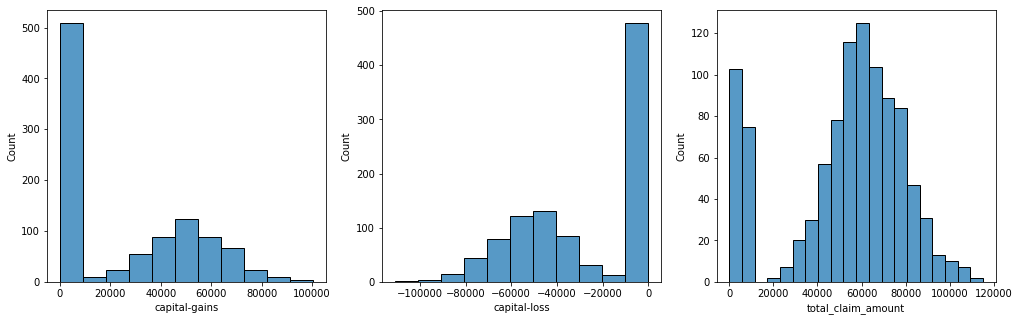

In [8]:
fig, ax = plt.subplots(1,3, figsize=(17,5))
sns.histplot(x='capital-gains', data=df1, ax=ax[0])
sns.histplot(x='capital-loss', data=df1, ax=ax[1])
sns.histplot(x='total_claim_amount', data=df1, ax=ax[2])

In [9]:
bins = [0, 10_000, 20_000, 30_000, 40_000, 50_000, 60_000, 70_000, 80_000, 90_000, 1_000_000]
bin_labels_capital_gains = ['0-10','10-20','20-30','30-40','40-50','50-60','60-70','70-80','80-90','90+']
df1['capital-gains'] = pd.cut(df1['capital-gains'], bins = bins, labels = bin_labels_capital_gains, include_lowest= True)

bins = [0, 10_000, 20_000, 30_000, 40_000, 50_000, 60_000, 70_000, 80_000, 90_000, 1_000_000]
bin_labels_capital_loss = ['0-10','10-20','20-30','30-40','40-50','50-60','60-70','70-80','80-90','90+']
df1['capital-loss'] = pd.cut(df1['capital-loss'].apply(lambda x:-x), bins = bins, labels = bin_labels_capital_loss, include_lowest= True)

bins = [0, 10_000, 20_000, 30_000, 40_000, 50_000, 60_000, 70_000, 80_000, 90_000, 100_000, 110_000, 1_000_000]
bin_labels_total = ['0-10','10-20','20-30','30-40','40-50','50-60','60-70','70-80','80-90','90-100', '100-110', '110+']
df1['total_claim_amount'] = pd.cut(df1['total_claim_amount'], bins = bins, labels = bin_labels_total, include_lowest= True)

# Splitting Validation
- Şu ana kadar uyguladığımız işlemleri hem train test hem de validation üzerinde uyguladık çünkü şuana kadar yaptığımız işlemler model canlıya alındığında gelen veriye kolaylıkla uygulayabileceğimiz işlemler. Şimdi ise validation verisini en güncel verilerdenden seçerek ayıracağız ve geri kalan işlemlere devam edeceğiz.

In [10]:
df1_val = df1.sort_values(by='incident_date',ascending=False).head(200)
df1 = df1.sort_values(by='incident_date',ascending=False).tail(800)

In [11]:
df1_val = df1_val.drop(["incident_date"],axis=1)
df1 = df1.drop(["incident_date"],axis=1).reset_index(drop=True)

# Encoding
## Encoding train
- Ordinal değişkenlere label encoding yapmak daha iyi sonuç vereceğini düşündüğüm için ve bizim gruplandırdığımız devamlı değişkenlerin hepsi ordinal olduğu için onlara label encoding, geri kalan kolonlara ise one hot encoding yapmaya karar verdim.

In [12]:
cat_cols = ['age_group', 'months_as_customer_groups', 'policy_annual_premium_groups', 'location_check', 'policy_deductable_group', 'capital-gains', 'capital-loss', 'total_claim_amount']
for col in cat_cols:
    df1[col] = df1[col].astype('object')

columns_to_encode = df1.select_dtypes(include='object').columns

columns_to_ordinal_encode= ['policy_csl', 'age_group', 'months_as_customer_groups', 'policy_annual_premium_groups', 'policy_deductable_group', 'capital-gains', 'capital-loss', 'total_claim_amount']

columns_to_onehot_encode = list(set(columns_to_encode) - set(columns_to_ordinal_encode))

In [13]:
# Doğru sırada encode edebilmek gruplandırırken oluşturduğumuz bin label'ları kullandım.
ordinal = OrdinalEncoder(categories = [['MISSING', '100/300', '250/500', '500/1000'],
                          bin_labels_age,
                          bin_labels_months,
                          bin_labels_policy_annual,
                          bin_labels_policy_deductable,
                          bin_labels_capital_gains,
                          bin_labels_capital_loss,
                          bin_labels_total
                         ], handle_unknown='use_encoded_value', unknown_value=-1) #Validation'da bilinmeyen bir değer gelirse -1 ile dolduracak
df1[columns_to_ordinal_encode] = pd.DataFrame(ordinal.fit_transform(df1[columns_to_ordinal_encode]), columns=columns_to_ordinal_encode)

In [14]:
one_hot = OneHotEncoder(handle_unknown='ignore', sparse=False)
one_hot_encoded = pd.DataFrame(one_hot.fit_transform(df1[columns_to_onehot_encode]))
df_encoded = pd.concat([df1.drop(columns_to_onehot_encode, axis=1),one_hot_encoded],axis=1)

In [15]:
y = df_encoded['fraud_reported'].copy()
X = df_encoded.drop('fraud_reported', axis=1)

## Encoding validation

In [16]:
df1_val.reset_index(drop=True,inplace=True)
df1_val[columns_to_ordinal_encode] = pd.DataFrame(ordinal.transform(df1_val[columns_to_ordinal_encode]), columns=columns_to_ordinal_encode)

In [17]:
one_hot_encoded = pd.DataFrame(one_hot.transform(df1_val[columns_to_onehot_encode].values))
df_val_encoded = pd.concat([df1_val.drop(columns_to_onehot_encode, axis=1),one_hot_encoded],axis=1)

In [18]:
y_val = df_val_encoded['fraud_reported'].copy()
X_val = df_val_encoded.drop('fraud_reported', axis=1)

# Modeller
- Uygulayacağımız pipeline'larda öncelikle SMOTE uygulayıp sonrasında, scale edip son olarak modele sokacağız. Tüm bu süreçler için hyperparameter tuning yapacağız. train-test split yerine kfold kullanarak bir kaç farklı şekilde bölmesini ve denemesini sağlayarak şans faktörünü azaltacağız. Imbalance bir veri seti olduğu için StratifiedKFold kullanacağız.
<!-- end of list -->

## Random Forest

In [19]:
from imblearn.pipeline import Pipeline

smote = SMOTE(random_state=73)
scaler = StandardScaler()
rfc = RandomForestClassifier(random_state=73)

pipe = Pipeline([
    ('smote', smote),
    ('scaler',scaler),
    ('rfc', rfc),
])

param_grid = {
    'smote__sampling_strategy': np.geomspace(0.5,0.8,5),
    'rfc__n_estimators': np.linspace(300, 1000,7, dtype='int64'),
    'rfc__max_depth': np.linspace(5,25,5,dtype='int64'),
    'rfc__min_samples_split': [2,5,10],
    'rfc__min_samples_leaf': [1,2,4],
}

score={
    'AUC':'roc_auc', 
    'RECALL':'recall',
}

kfold = StratifiedKFold(n_splits=4)

grid = RandomizedSearchCV(pipe, param_grid, n_iter=50, cv=kfold, scoring=score, refit='RECALL', return_train_score=True,verbose=1, random_state=73, n_jobs=3)

In [20]:
grid.fit(X,y)

Fitting 4 folds for each of 50 candidates, totalling 200 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('smote', SMOTE(random_state=73)),
                                             ('scaler', StandardScaler()),
                                             ('rfc',
                                              RandomForestClassifier(random_state=73))]),
                   n_iter=50, n_jobs=3,
                   param_distributions={'rfc__max_depth': array([ 5, 10, 15, 20, 25]),
                                        'rfc__min_samples_leaf': [1, 2, 4],
                                        'rfc__min_samples_split': [2, 5, 10],
                                        'rfc__n_estimators': array([ 300,  416,  533,  650,  766,  883, 1000]),
                                        'smote__sampling_strategy': array([0.5       , 0.56234133, 0.63245553, 0.71131176, 0.8       ])},
                   random_state=73, refit='RECALL', return_train_score=True,
         

In [21]:
grid.best_params_

{'smote__sampling_strategy': 0.8,
 'rfc__n_estimators': 883,
 'rfc__min_samples_split': 10,
 'rfc__min_samples_leaf': 1,
 'rfc__max_depth': 15}

              precision    recall  f1-score   support

           0       0.93      0.80      0.86       163
           1       0.45      0.73      0.56        37

    accuracy                           0.79       200
   macro avg       0.69      0.76      0.71       200
weighted avg       0.84      0.79      0.80       200



<AxesSubplot:>

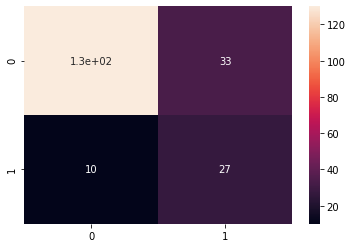

In [22]:
preds = grid.predict(X_val)
print(classification_report(y_val,preds))
sns.heatmap(confusion_matrix(y_val, preds), annot=True)

## Support Vector Classifier
- SVM'de SMOTE kullanmaya gerek yok çünkü algoritmanın içinde halihazırda imbalanced datasetler için bir method var. class_weight argümanı 'balanced' yapıldığında datasetin imbalance'lığına ters oranda ihtimalleri değiştirerek kendi kendine dengelemiş oluyor.

In [23]:
scaler = StandardScaler()
svc = SVC(class_weight='balanced',random_state=73)

X_n = scaler.fit_transform(X)
X_val_n = scaler.transform(X_val)


param_grid2 = {
    'C': [0.1, 1, 2, 10],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['linear','rbf']
}

kfold = StratifiedKFold(n_splits=4)

grid2 = RandomizedSearchCV(svc, param_grid2, n_iter=20, cv=kfold, verbose=1, random_state=73, n_jobs=3)

In [24]:
grid2.fit(X_n,y)

Fitting 4 folds for each of 20 candidates, totalling 80 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=False),
                   estimator=SVC(class_weight='balanced', random_state=73),
                   n_iter=20, n_jobs=3,
                   param_distributions={'C': [0.1, 1, 2, 10],
                                        'gamma': [1, 0.1, 0.01, 0.001],
                                        'kernel': ['linear', 'rbf']},
                   random_state=73, verbose=1)

In [25]:
grid2.best_params_

{'kernel': 'rbf', 'gamma': 0.001, 'C': 2}

              precision    recall  f1-score   support

           0       0.95      0.79      0.86       163
           1       0.46      0.81      0.59        37

    accuracy                           0.79       200
   macro avg       0.70      0.80      0.72       200
weighted avg       0.86      0.79      0.81       200



<AxesSubplot:>

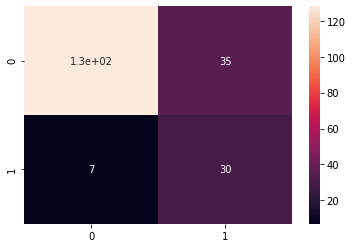

In [26]:
preds = grid2.predict(X_val_n)
print(classification_report(y_val,preds))
sns.heatmap(confusion_matrix(y_val, preds), annot=True)

- Random Forest'a göre daha iyi sonuçlar. Özellikle recall değerlerine bakacak olursak, bu model fraud'ların %81'ini yakalamış. Ayrıca precision'a bakacak olursak da fraud olarak tahmin ettiği verilerin yaklaşık yarısı gerçekten fraud. Bu aslında fraud olup olmadığını inceleyecek uzmanlara fraud sayısının 2 katı kadar dosya gitmesi anlamına geliyor.

# Gradient Boosting Classifier

In [27]:
smote = SMOTE(random_state=73)
scaler = StandardScaler()
gbc = GradientBoostingClassifier()

pipe3 = Pipeline([
    ('smote', smote),
    ('scaler',scaler),
    ('gbc', gbc),
])

param_grid3 = {
    'smote__sampling_strategy': np.geomspace(0.5,0.8,5),
    'gbc__n_estimators': np.linspace(75, 400,7, dtype='int64'),
    'gbc__max_depth': np.linspace(5,20,5,dtype='int64'),
    'gbc__subsample': np.linspace(0.5,1,5),
}

score={
    'AUC':'roc_auc', 
    'RECALL':'recall',
}

kfold = StratifiedKFold(n_splits=4)

grid3 = RandomizedSearchCV(pipe3, param_grid3, n_iter=50, cv=kfold, scoring=score, refit='RECALL', return_train_score=True,verbose=1, random_state=73, n_jobs=3)

In [28]:
grid3.fit(X_n,y)

Fitting 4 folds for each of 50 candidates, totalling 200 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('smote', SMOTE(random_state=73)),
                                             ('scaler', StandardScaler()),
                                             ('gbc',
                                              GradientBoostingClassifier())]),
                   n_iter=50, n_jobs=3,
                   param_distributions={'gbc__max_depth': array([ 5,  8, 12, 16, 20]),
                                        'gbc__n_estimators': array([ 75, 129, 183, 237, 291, 345, 400]),
                                        'gbc__subsample': array([0.5  , 0.625, 0.75 , 0.875, 1.   ]),
                                        'smote__sampling_strategy': array([0.5       , 0.56234133, 0.63245553, 0.71131176, 0.8       ])},
                   random_state=73, refit='RECALL', return_train_score=True,
                   scoring={'AUC': 'roc_auc', 'RECALL': 'recall'}, verbose=1)

In [29]:
grid3.best_params_

{'smote__sampling_strategy': 0.7113117640155692,
 'gbc__subsample': 0.5,
 'gbc__n_estimators': 75,
 'gbc__max_depth': 20}

              precision    recall  f1-score   support

           0       0.94      0.80      0.86       163
           1       0.46      0.76      0.57        37

    accuracy                           0.79       200
   macro avg       0.70      0.78      0.72       200
weighted avg       0.85      0.79      0.81       200



<AxesSubplot:>

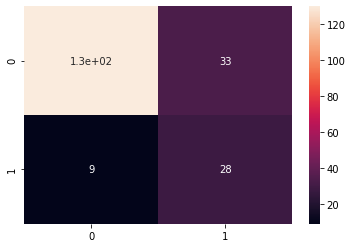

In [30]:
preds = grid3.predict(X_val_n)
print(classification_report(y_val,preds))
sns.heatmap(confusion_matrix(y_val, preds), annot=True)

- SVM'ye göre daha kötü sonuçlar.
## Threshold Değiştirme
- Bu sefer threshold değerini değiştirerek alacağımız sonucu değerlendireceğimiz için train_test_split kullandıktan sonra train üzerinde smote uygulayıp, testte uygulamayarak farklı thresholdlarda test datasetimizin aldığı sonuçları inceleyeceğiz. Bu şekilde en uygun threshold değerini bulup validation üzerinde deneyeceğiz.

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=73)
smote = SMOTE(random_state=73)
X_train, y_train = smote.fit_resample(X_train,y_train)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

rfc = RandomForestClassifier(n_estimators=750,max_depth=5, random_state=73)
rfc.fit(X_train, y_train)

thresholds = np.linspace(0.2,0.7,100)
results0 = []
results1 = []

for i in thresholds:
    preds = (rfc.predict_proba(X_test)[:,1]>i).astype(int)
    results0.append(recall_score(y_test, preds, average=None)[0])
    results1.append(recall_score(y_test, preds, average=None)[1])

<AxesSubplot:>

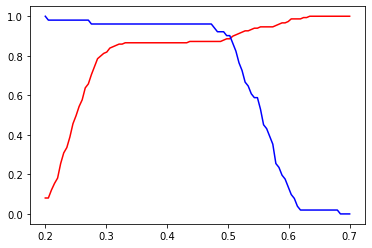

In [32]:
sns.lineplot(x=thresholds, y=results0, color='red')
sns.lineplot(x=thresholds, y=results1, color='blue')

- Grafikte farklı threshold değerlerinde, 0 ve 1 değerleri için recall değerleri görülmektedir. Beklendiği gibi uç threshold değerlerde recall değerlerinden biri 0'a diğeri 1'e yaklaşmaktadır. Bizim aradığımız değerler 0 ve 1'in recall değerlerinin birbirine yakın olduğu optimal durumdur, yani aslında grafikte 0.3-0.55 aralığındaki değerler bizim aradığımız aralıktır. Çok geniş bir aralık çıktığı için modelimizin aslında threshold değişiminden pek etkilenmediği görülmüştür. Yine de o aralığın ortasındaki değer olan 0.4 ile tekrar denemek modeli az da olsa geliştirebilir.

              precision    recall  f1-score   support

           0       0.95      0.79      0.86       163
           1       0.46      0.81      0.59        37

    accuracy                           0.79       200
   macro avg       0.70      0.80      0.72       200
weighted avg       0.86      0.79      0.81       200



<AxesSubplot:>

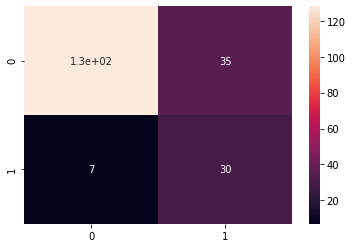

In [33]:
preds = (rfc.predict_proba(X_val)[:,1]>0.40).astype(int)
print(classification_report(y_val,preds))
sns.heatmap(confusion_matrix(y_val, preds), annot=True)

- Ufak bir artışla SVC modelimizle aynı sonuçlara geldi.
## Sonuçlar
- Bu modellerin yanı sıra KNN modelini denedim, VotingClassifier kullanarak farklı modelleri bir araya getirerek ensemble bir model oluşturmayı denedim fakat buradaki modellerden daha düşük recall değerleri aldığım için onları çalışmamdan çıkardım.
- Sonuç olarak fraud'ları da not fraud'ları da %80 oranla tahminleyebilen bir modele ulaşıldı. Ayrıca bu modellerin fraud diye raporladığı case'lerin yaklaşık olarak yarısı gerçekten fraud. Şirketin isteklerine göre threshold değiştirilerek bu iki değerden biri düşürülürken diğeri arttırılabilir.
- Örneğin daha fazla fraud yakalamak için recall değeri artırılarak precision değeri düşürülebilir. Bu sayede daha fazla fraud yakalanmış olur fakat fraud olarak seçilen dosya sayısı daha da artmış olur. Yani fraud olarak gönderilen dosyaların yarısından daha da azı fraud olmuş olur. Bu da daha fazla iş gücü gerektirir.
- Veya tam tersi precision arttırılarak, uzmanlara gönderilen dosyaların yarısından daha fazlasının gerçekten fraud olması sağlanabilir. Bu durumda ihtiyaç olan iş gücü azalacaktır fakat bu durumda da modelin yakaladığı fraud oranı azalacaktır.
- Bu ikisi arasındaki denge bu modeli kullanacak şirketin politikaları, iş gücü ve istekleri doğrultusunda kurulmalıdır.